<a href="https://colab.research.google.com/drive/14a3WjNXvnn090RYpycahSRGneIQysbE1?authuser=2#scrollTo=sReEIgMZAGk8" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network (CNN)

## 1. Load dataset

In [1]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_500.zip -d ./data500

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 63.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 157MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 224MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
To: /content/dataset/data_3000.zip
100% 3.31M/

## 2. Import python libraries and define util functions

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 22.6 MB/s eta 0:00:00


In [3]:
import numpy as np  # library for numerical calculations
import pandas as pd  # data analysis library
import cv2 as cv  # computer vision library for image processing
import matplotlib.pyplot as plt  # visualization library for charts and plots
import os  # operating system library for file handling

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  # model optimization
from torch.utils.data import DataLoader, TensorDataset  # dataset management
from torchmetrics.functional.regression import mean_squared_error  # regression metric: MSE
from torchmetrics.functional.regression import mean_absolute_percentage_error  # regression metric: MAPE
from torchsummary import summary  # model summary

from sklearn.model_selection import train_test_split  # split data into training and testing sets

# function to plot a line graph for RMSE history after model training
def plot_rmse(rmse_train_history, rmse_valid_history, title=None):

    plt.plot(rmse_train_history)
    plt.plot(rmse_valid_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('RMSE')
    plt.xlabel('Epochs')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

# function to plot a line graph for MAPE history after model training
def plot_mape(mape_train_history, mape_valid_history, title=None):

    plt.plot(mape_train_history)
    plt.plot(mape_valid_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('MAPE')
    plt.xlabel('Epochs')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

# function to plot a line graph for loss history after model training
def plot_loss(loss_train_history, loss_valid_history, title=None):

    plt.plot(loss_train_history)
    plt.plot(loss_valid_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

print(torch.__version__)  # check the PyTorch version

2.4.0+cu121


## 3. Dataset check

In [ ]:
path = './data500/26.831.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

## 3. Convert images into trainable data

0


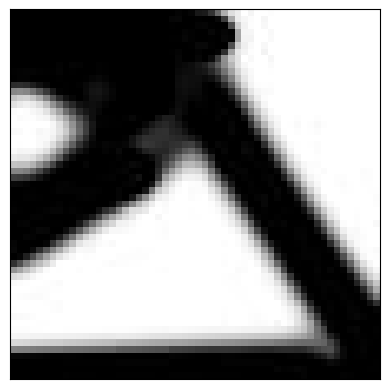

1


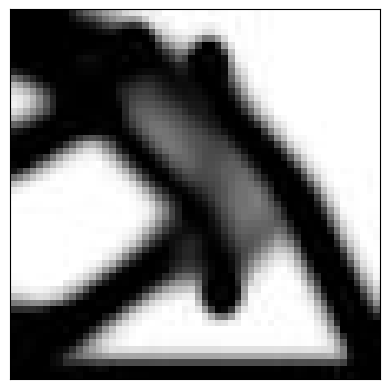

2


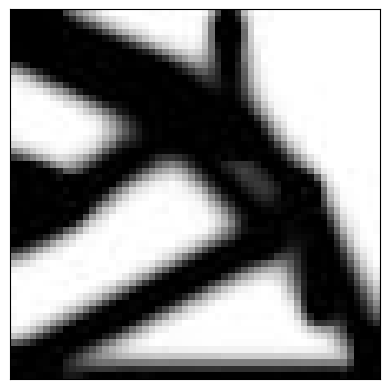

3


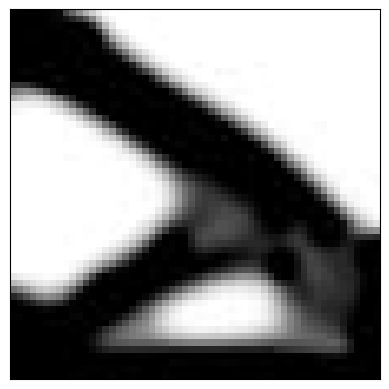

4


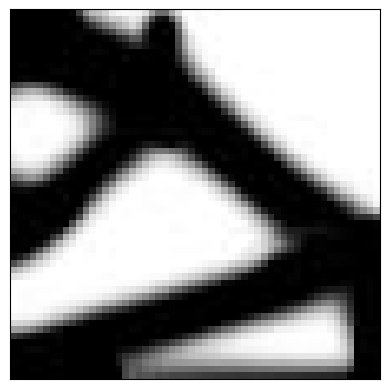

5


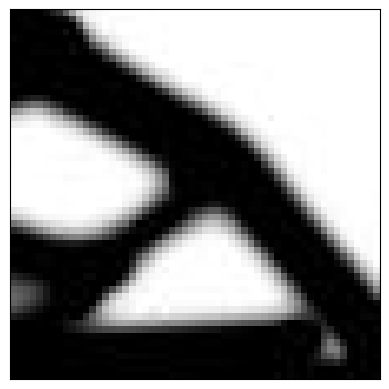

6


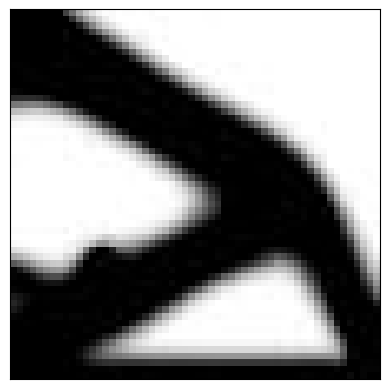

7


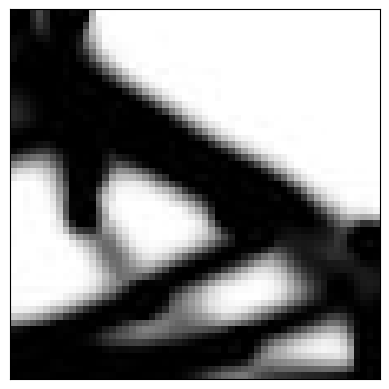

8


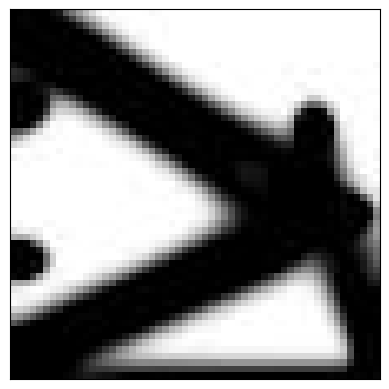

9


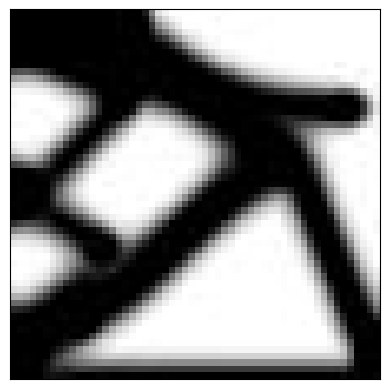

X_shape: (56, 56) Y_shape: ()
X_list shape: (500, 56, 56) Y_list shape: (500,)


In [5]:
# image size = 56 x 56, 500 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data500/'

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels
count = 0

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
  # Check few of the data.
    if count < 10:
        print(count)
        X.append(img_read_plot(src,file)/255.)  # normalize the image by dividing by 255
        Y.append(float(file[:-4]))  # extract label from filename
        count+=1
    else:
        X.append(img_read(src,file)/255.)  # normalize the image
        Y.append(float(file[:-4]))  # extract label from filename

# convert the data to array
X = np.array(X)
Y = np.array(Y)

# check the shape of the data
print('X_shape:',np.shape(X[0]),'Y_shape:',np.shape(Y[0]))
print('X_list shape:',np.shape(X),'Y_list shape:',np.shape(Y))

## 4. Define dataloader

In [6]:
# split the data into 80% training set and 20% test set (test set can be considered as validation)
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)

# print the shapes and types of the training and test datasets
print(np.shape(train_images), np.shape(test_images))
print(type(train_images), type(test_images))

print(np.shape(train_labels),np.shape(test_labels))
print(type(train_labels), type(test_labels))

# convert the numpy arrays to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

# reshape the data for model training
train_images = train_images.reshape(400,-1,56,56).to('cuda')
test_images = test_images.reshape(100,-1,56,56).to('cuda')

# print the new sizes and types of the training and test datasets after reshaping
print(train_images.size(), test_images.size())
print(type(train_images),  type(test_images))

# reshape the labels for training
train_labels = train_labels.reshape(400,-1)
test_labels = test_labels.reshape(100,-1)

# print the new sizes and types of the labels after reshaping
print(train_labels.size(), test_labels.size())
print(type(train_labels),  type(test_labels))

(400, 56, 56) (100, 56, 56)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(400,) (100,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
torch.Size([400, 1, 56, 56]) torch.Size([100, 1, 56, 56])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([400, 1]) torch.Size([100, 1])
<class 'torch.Tensor'> <class 'torch.Tensor'>


## 5. Set to model architecture

In [7]:
class CNN_Model(nn.Module):
    def __init__(self, num_conv_layers=3, conv_channels=[16, 32, 64], fc_units=[256, 1]):
        super(CNN_Model, self).__init__()

        # define the convolutional layers
        self.convs = nn.ModuleList()
        in_channels = 1  # input channels (1 for grayscale images)
        for i in range(num_conv_layers):
            out_channels = conv_channels[i]
            self.convs.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1))
            in_channels = out_channels  # set the output channels of this layer as input for the next layer

        self.relu = nn.ReLU()  # ReLU activation function
        self.maxpool = nn.MaxPool2d(kernel_size=2)  # Max-pooling with a kernel size of 2

        # calculate the size of the flattened feature map after the convolutional layers
        conv_output_size = in_channels * (56 // (2 ** num_conv_layers)) * (56 // (2 ** num_conv_layers))

        # define the fully connected layers
        self.flatten = nn.Flatten()  # flatten the feature map to prepare for fully connected layers
        self.fcs = nn.ModuleList()
        input_dim = conv_output_size
        for fc_unit in fc_units[:-1]:  # create the hidden fully connected layers
            self.fcs.append(nn.Linear(input_dim, fc_unit))
            input_dim = fc_unit  # update input size for the next fully connected layer

        # define the output layer
        self.fc_out = nn.Linear(input_dim, fc_units[-1])

    def forward(self, x):
        # pass the input through the convolutional layers with ReLU and MaxPooling
        for conv in self.convs:
            x = self.relu(conv(x))
            x = self.maxpool(x)

        # flatten the output from the convolutional layers
        x = self.flatten(x)

        # pass the flattened output through the fully connected layers with ReLU
        for fc in self.fcs:
            x = self.relu(fc(x))

        # pass the output through the final layer
        x = self.fc_out(x)

        return x

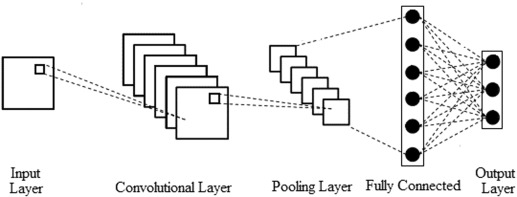

## 6. (Optional) Set model hyperparameters

In [8]:
# model architecture parameters

# Example usage:
# - num_conv_layers: number of convolutional layers in the model
# - conv_channels: list of output channels for each convolutional layer (controls the depth of features learned at each layer)
# - fc_units: list of units for fully connected layers, where the last value determines the output size

# dafault settings; you can change the parameters if needed
model = CNN_Model(num_conv_layers=3, conv_channels=[64, 128, 256], fc_units=[256, 1]).to("cuda")

# ------------------------------
# Hyperparameter tuning example:
# - Increasing the number of convolutional layers (num_conv_layers)
# - Increasing the number of output channels in the convolutional layers (conv_channels)
# - Adjusting the units in the fully connected layers to see how it affects the performance (fc_units)
# These changes might help the model learn more complex patterns (e.g. increasing # of total params), improving accuracy
# model = CNN_Model(num_conv_layers=4, conv_channels=[32, 64, 128, 256], fc_units=[512, 256, 1]).to("cuda")  # 4 convolutional layers and a deeper fully connected layer
# ------------------------------


# print the model's summary for an overview of its structure
summary(model, (1, 56, 56))  # input shape: (channels, height, width)

model  # print model architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]             640
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 128, 28, 28]          73,856
              ReLU-5          [-1, 128, 28, 28]               0
         MaxPool2d-6          [-1, 128, 14, 14]               0
            Conv2d-7          [-1, 256, 14, 14]         295,168
              ReLU-8          [-1, 256, 14, 14]               0
         MaxPool2d-9            [-1, 256, 7, 7]               0
          Flatten-10                [-1, 12544]               0
           Linear-11                  [-1, 256]       3,211,520
             ReLU-12                  [-1, 256]               0
           Linear-13                    [-1, 1]             257
Total params: 3,581,441
Trainable param

CNN_Model(
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fcs): ModuleList(
    (0): Linear(in_features=12544, out_features=256, bias=True)
  )
  (fc_out): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
# training parameters

learning_rate = 0.0001  # The rate at which the model learns; smaller values can lead to more precise learning, but too small may slow down training
batch_size = 32  # Number of samples processed before updating the model; Increasing batch size can improve training speed, but requires more memory
training_epochs = 100  # Number of times the entire training dataset is passed through the model; More epochs allow the model to learn better but may lead to overfitting

## 7. Train model

In [10]:
# create a DataLoader for the training dataset (includes shuffling)
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# define the loss function (MSE: Mean Squared Error)
criterion = nn.MSELoss()

# set the optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# lists to track training and validation history
loss_train_history = []
rmse_train_history = []
mape_train_history = []

loss_valid_history = []
rmse_valid_history = []
mape_valid_history = []


for epoch in range(training_epochs):

    # training phase
    model.train()  # set the model to training mode
    total_loss = 0.0
    rmse_train = 0.0
    mape_train = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # reset the gradients
        outputs = model(images).to('cuda')
        labels = labels.to('cuda')
        loss = criterion(outputs, labels)  # calculate the loss
        loss.backward()  # backpropagate the loss
        optimizer.step()  # update the model parameters

        # accumulate metrics
        total_loss += loss.item()
        rmse_train += mean_squared_error(outputs, labels, squared=False).item() # returns RMSE value if set to False
        mape_train += mean_absolute_percentage_error(outputs, labels).item() * 100

    # calculate average metrics for the training set
    average_loss_train = total_loss / len(train_loader)
    average_rmse_train = rmse_train / len(train_loader)
    average_mape_train = mape_train / len(train_loader)

    # save training metrics
    loss_train_history.append(average_loss_train)
    rmse_train_history.append(average_rmse_train)
    mape_train_history.append(average_mape_train)

    # convert the test dataset from numpy to PyTorch tensors and move to GPU
    test_images = torch.tensor(test_images).float().to('cuda')
    test_labels = torch.tensor(test_labels).float().to('cuda')

    # evaluation phase (disable gradient calculation)
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_images).to('cuda')
        loss_val = criterion(test_outputs, test_labels).item()  # calculate the validation loss
        rmse_val = mean_squared_error(test_outputs, test_labels, squared=False).item()  # RMSE for the validation set
        mape_val = mean_absolute_percentage_error(test_outputs, test_labels).item() * 100  # MAPE for the validation set

    # save training metrics
    loss_valid_history.append(loss_val)
    rmse_valid_history.append(rmse_val)
    mape_valid_history.append(mape_val)

    # print training and validation metrics for the current epoch
    print(f"Epoch [{epoch+1}/{training_epochs}], TRAIN_RMSE: {average_rmse_train:.4f}, TRAIN_MAPE: {average_mape_train:.4f}, VAL_RMSE: {rmse_val:.4f}, VAL_MAPE: {mape_val:.4f}")

<ipython-input-10-81547b86bd6c>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_images = torch.tensor(test_images).float().to('cuda')
<ipython-input-10-81547b86bd6c>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).float().to('cuda')


Epoch [1/100], TRAIN_RMSE: 23.8687, TRAIN_MAPE: 88.1382, VAL_RMSE: 15.4084, VAL_MAPE: 57.1160
Epoch [2/100], TRAIN_RMSE: 8.1673, TRAIN_MAPE: 29.8027, VAL_RMSE: 3.7685, VAL_MAPE: 13.3308
Epoch [3/100], TRAIN_RMSE: 3.9525, TRAIN_MAPE: 13.4701, VAL_RMSE: 2.5641, VAL_MAPE: 8.0289
Epoch [4/100], TRAIN_RMSE: 2.3018, TRAIN_MAPE: 7.4076, VAL_RMSE: 1.5712, VAL_MAPE: 4.9169
Epoch [5/100], TRAIN_RMSE: 1.6962, TRAIN_MAPE: 5.0784, VAL_RMSE: 1.4188, VAL_MAPE: 4.4057
Epoch [6/100], TRAIN_RMSE: 1.5305, TRAIN_MAPE: 4.9227, VAL_RMSE: 1.4253, VAL_MAPE: 4.3281
Epoch [7/100], TRAIN_RMSE: 1.5087, TRAIN_MAPE: 4.7199, VAL_RMSE: 1.4861, VAL_MAPE: 4.6487
Epoch [8/100], TRAIN_RMSE: 1.4836, TRAIN_MAPE: 4.7568, VAL_RMSE: 1.4156, VAL_MAPE: 4.3033
Epoch [9/100], TRAIN_RMSE: 1.4766, TRAIN_MAPE: 4.7411, VAL_RMSE: 1.4003, VAL_MAPE: 4.3351
Epoch [10/100], TRAIN_RMSE: 1.4882, TRAIN_MAPE: 4.8120, VAL_RMSE: 1.4133, VAL_MAPE: 4.4007
Epoch [11/100], TRAIN_RMSE: 1.4852, TRAIN_MAPE: 4.7093, VAL_RMSE: 1.4663, VAL_MAPE: 4.5880
E

## 8. Visualize learning history

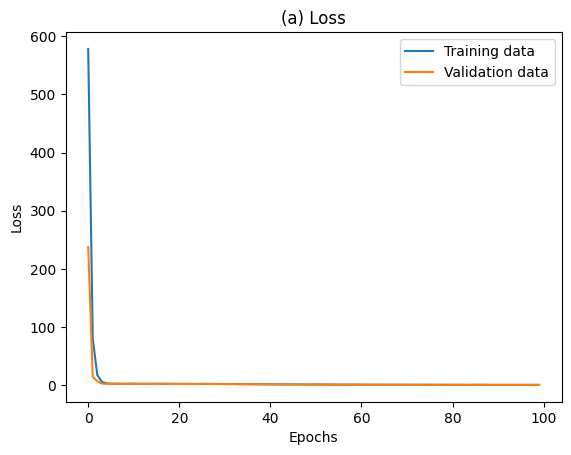

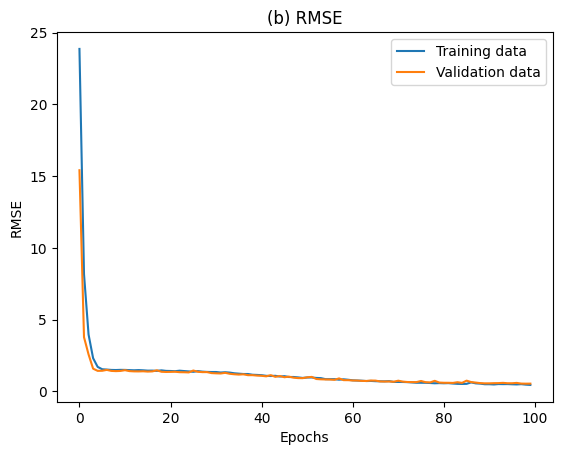

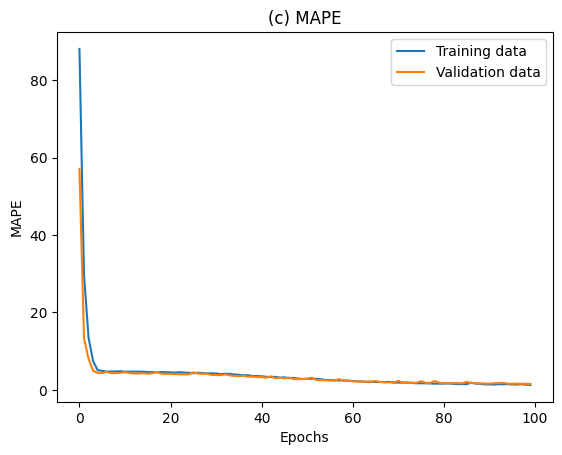

In [12]:
# Graph Visualization
plot_loss(loss_train_history, loss_valid_history, '(a) Loss')  # Loss variation over epochs during training
plt.show()
plot_rmse(rmse_train_history, rmse_valid_history, '(b) RMSE')  # RMSE variation over epochs during training
plt.show()
plot_mape(mape_train_history, mape_valid_history, '(c) MAPE')  # MAPE variation over epochs during training
plt.show()

## 9. Evaluate model performance

 ----- evaluation results ----- 
 
valid RMSE :  0.5286
valid MAPE :  0.0155
valid R2 :  0.9329


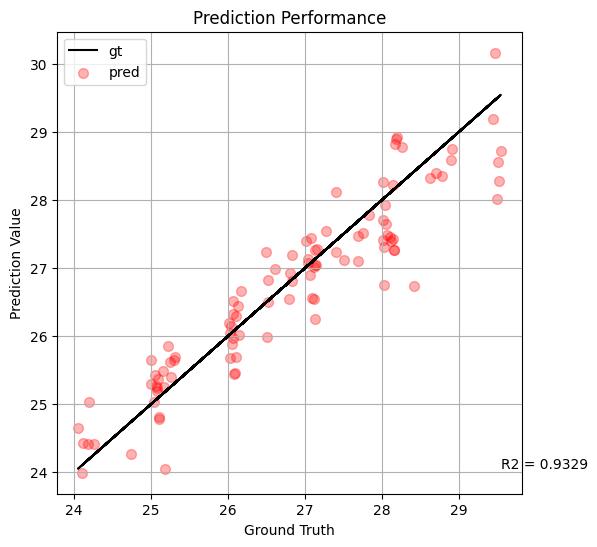

In [13]:
# load the saved model and set it to evaluation mode
model.eval().to('cuda')

# function to calculate the R2
def r_val(true,pred):  # R2 : Coefficient of determination

    true = pd.DataFrame(true)
    pred = pd.DataFrame(pred)
    result = true.corrwith(pred, method='pearson')
    return (np.round(result,4)[0])

# predict using the model (on the validation dataset)
pred_labels = model(test_images)  # returns the predicted values (y_pred)

# evaluate the model performance (RMSE & MAPE)
each_rmse_test = mean_squared_error(pred_labels, test_labels, squared=False).item()
each_mape_test = mean_absolute_percentage_error(test_labels, pred_labels).item()

# calculate and visualize the R2
pred_labels = pred_labels.cpu().detach().numpy()
test_labels = test_labels.cpu().numpy()

plt.figure(figsize=(6,6))
plt.plot(test_labels, test_labels,'-',color='black')
plt.scatter(test_labels, pred_labels,s=50,alpha=0.3,color='red')
plt.legend(['gt','pred'],loc='upper left')
plt.title('Prediction Performance')
plt.text(test_labels.max(),test_labels.min(),'R2 = {}'.format(round(r_val(test_labels, pred_labels),4)))
plt.xlabel('Ground Truth')
plt.ylabel('Prediction Value')
plt.grid(True)


# fine-tune your model by minimizing rmse value (validation dataset)
print(" ----- evaluation results ----- ")
print(" ")
print("valid RMSE : " , np.round(each_rmse_test,4))
print("valid MAPE : " , np.round(each_mape_test,4))
print("valid R2 : " , r_val(test_labels, pred_labels))